In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000,5.450000
...,...,...,...,...,...,...
2019-12-11,71.438004,70.218002,70.375999,70.540001,34489000,70.540001
2019-12-12,72.547997,70.646004,70.984001,71.935997,38819500,71.935997
2019-12-13,73.042000,70.928001,72.209999,71.678001,32854500,71.678001


In [3]:
df.shape

(2003, 6)

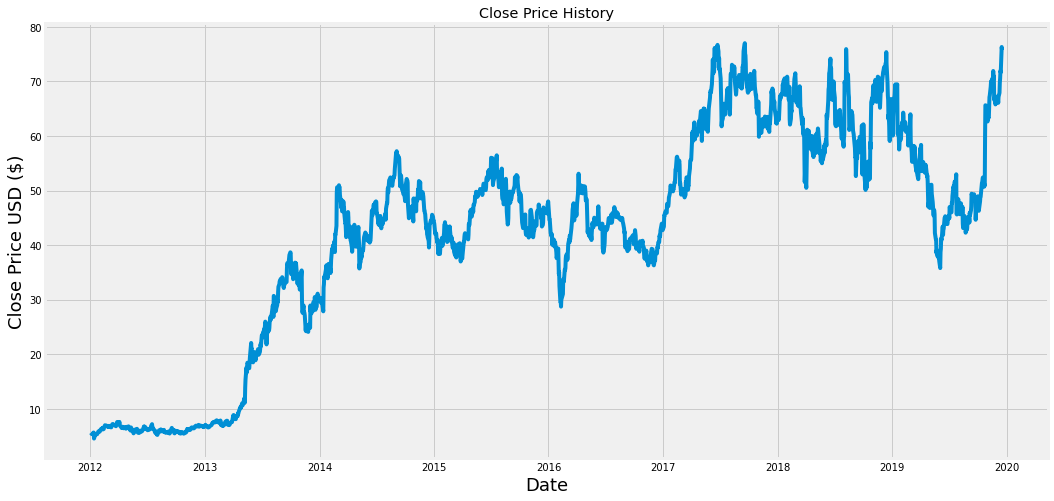

In [4]:
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01460479],
       [0.01358328],
       [0.01195439],
       ...,
       [0.92653435],
       [0.99033714],
       [0.98340737]])

In [7]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.01460479, 0.01358328, 0.01195439, 0.01137462, 0.0123133 ,
       0.01333481, 0.01501891, 0.01507413, 0.        , 0.01051876,
       0.01109853, 0.01096049, 0.01051876, 0.0109881 , 0.01278264,
       0.01430109, 0.0169791 , 0.01805583, 0.01871842, 0.01733801,
       0.01874603, 0.02059579, 0.02308053, 0.02487507, 0.02432291,
       0.02523398, 0.02702852, 0.02294249, 0.02401921, 0.02865741,
       0.02984456, 0.03144584, 0.0336269 , 0.03232931, 0.03155628,
       0.03241214, 0.03025869, 0.02989978, 0.03042434, 0.02932001,
       0.03208084, 0.03105933, 0.03031391, 0.02849176, 0.02851937,
       0.02838132, 0.03299191, 0.03649816, 0.03671903, 0.03451037,
       0.03370973, 0.03459319, 0.03365451, 0.03359929, 0.03412385,
       0.03205323, 0.03116976, 0.04033572, 0.04182656, 0.04157809])]
[0.04014245873792312]

[array([0.01460479, 0.01358328, 0.01195439, 0.01137462, 0.0123133 ,
       0.01333481, 0.01501891, 0.01507413, 0.        , 0.01051876,
       0.01109853, 0.01096049, 0.01

In [8]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 57s 34ms/step - loss: 0.0027


In [13]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [14]:
x_test = np.array(x_test)

In [15]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 0s 21ms/step


In [19]:
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

0.1792537021636963

<ipython-input-20-923adb63e645>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


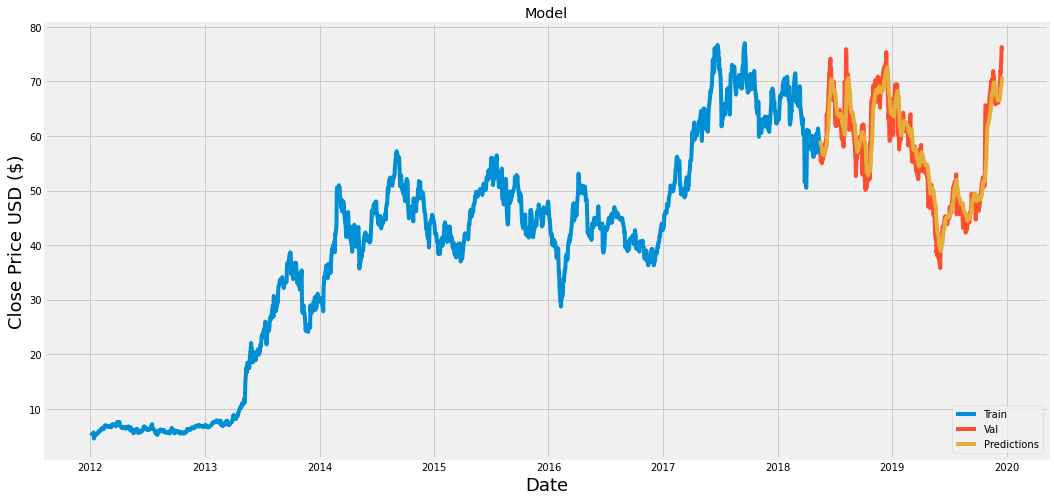

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
valid

,Close,Predictions
Date,,
2018-05-17,56.908001,59.154125
2018-05-18,55.363998,58.634670
2018-05-21,56.897999,57.977200
2018-05-22,55.001999,57.623127
2018-05-23,55.813999,57.139435
...,...,...
2019-12-11,70.540001,67.297325
2019-12-12,71.935997,67.982292
2019-12-13,71.678001,68.829514


In [26]:
tesla_qoute = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-11')
new_df = tesla_qoute.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print(predicted_price)

1/1 [==============================] - 0s 28ms/step
[[67.98229]]


In [28]:
tesla_quote2 = web.DataReader('TSLA', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(tesla_quote2['Close'])

Date
2019-12-18    78.629997
Name: Close, dtype: float64
